In [43]:
import pandas as pd

# Load the pipe-delimited .txt file
df = pd.read_csv('../data/raw/MachineLearningRating_v3.txt', delimiter='|', low_memory=False)

# View basic structure
df.shape
df.head()

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


In [44]:
# Check column info
df.info()

# Percentage of missing values
missing = df.isnull().mean().sort_values(ascending=False)
missing[missing > 0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   UnderwrittenCoverID       1000098 non-null  int64  
 1   PolicyID                  1000098 non-null  int64  
 2   TransactionMonth          1000098 non-null  object 
 3   IsVATRegistered           1000098 non-null  bool   
 4   Citizenship               1000098 non-null  object 
 5   LegalType                 1000098 non-null  object 
 6   Title                     1000098 non-null  object 
 7   Language                  1000098 non-null  object 
 8   Bank                      854137 non-null   object 
 9   AccountType               959866 non-null   object 
 10  MaritalStatus             991839 non-null   object 
 11  Gender                    990562 non-null   object 
 12  Country                   1000098 non-null  object 
 13  Province                  1

NumberOfVehiclesInFleet    1.000000
CrossBorder                0.999302
CustomValueEstimate        0.779566
Rebuilt                    0.641838
Converted                  0.641838
WrittenOff                 0.641838
NewVehicle                 0.153280
Bank                       0.145947
AccountType                0.040228
Gender                     0.009535
MaritalStatus              0.008258
NumberOfDoors              0.000552
VehicleType                0.000552
kilowatts                  0.000552
cubiccapacity              0.000552
Cylinders                  0.000552
Model                      0.000552
make                       0.000552
VehicleIntroDate           0.000552
bodytype                   0.000552
mmcode                     0.000552
CapitalOutstanding         0.000002
dtype: float64

In [45]:
claim_data = df[df['TotalClaims'] > 0].copy()

In [46]:
if 'TotalClaimAmount' not in claim_data.columns:
    claim_data['TotalClaimAmount'] = claim_data['TotalPremium'] / claim_data['TotalClaims']

In [47]:
# Remove columns that leak the target
drop_cols = ['TotalPremium', 'TotalClaims']
X = claim_data.drop(columns=drop_cols + ['TotalClaimAmount'], errors='ignore')
y = claim_data['TotalClaimAmount']


In [48]:
# Only use numeric columns at first
X = X.select_dtypes(include=['number'])


In [53]:
# Drop columns that are entirely null
X = X.dropna(axis=1, how='all')

# Then proceed with imputation and scaling
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_imputed)


In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [56]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest R^2:", r2_score(y_test, y_pred_rf))


Random Forest RMSE: 1.3362933305749418
Random Forest R^2: -71.31718951363958


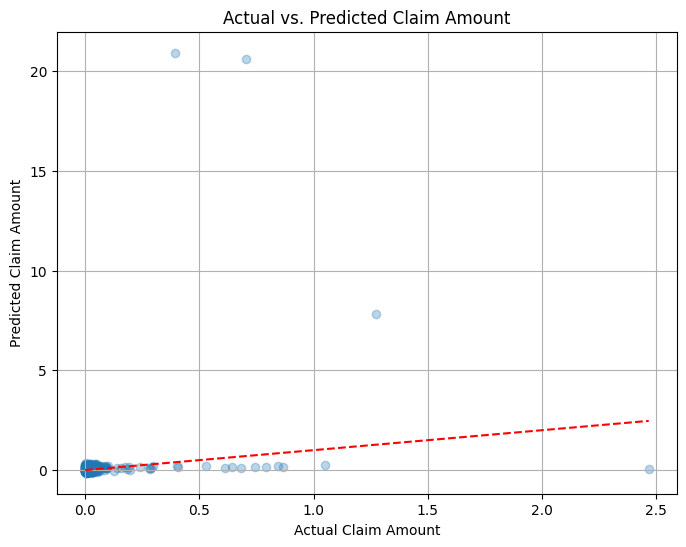

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Claim Amount")
plt.ylabel("Predicted Claim Amount")
plt.title("Actual vs. Predicted Claim Amount")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid()
plt.show()


In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"Random Forest R²: {rf_r2:.4f}")


Random Forest RMSE: 1.34
Random Forest R²: -71.3172


In [58]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {xgb_rmse:.2f}")
print(f"XGBoost R²: {xgb_r2:.4f}")


XGBoost RMSE: 1.35
XGBoost R²: -72.8379


In [59]:
categorical_cols = ['Province', 'VehicleType', 'Gender', 'Language', 'CoverType']
categorical_df = claim_data[categorical_cols].astype('category')


In [60]:
# One-hot encode
encoded_df = pd.get_dummies(categorical_df, drop_first=True)

# Combine with numeric features
numeric_df = claim_data.select_dtypes(include=['number']).drop(columns=['TotalPremium', 'TotalClaims', 'TotalClaimAmount'], errors='ignore')
X = pd.concat([numeric_df, encoded_df], axis=1)
y = claim_data['TotalClaimAmount']


/Users/mikiyasegaye/MK_Lab/10 Academy/Risk-Analytics-Predictive-Modeling/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


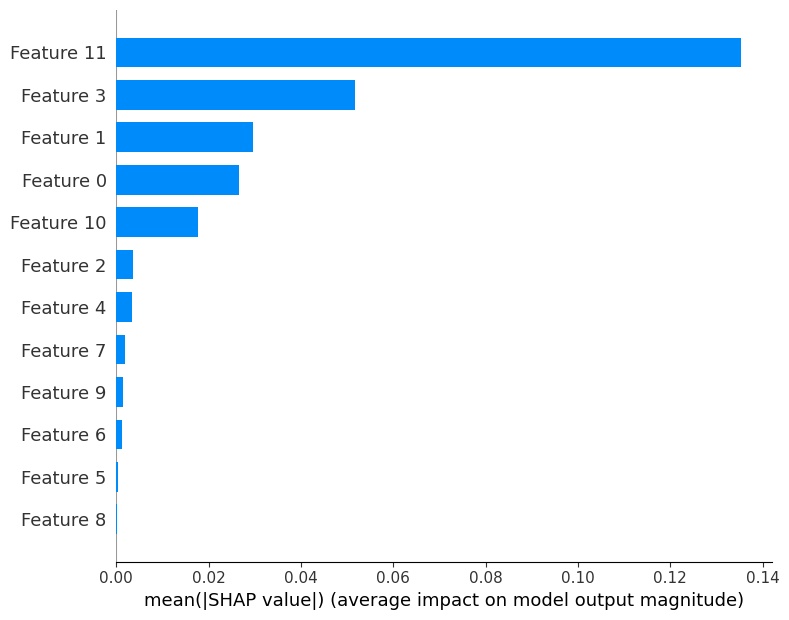

In [61]:
import shap

# Create SHAP explainer for XGBoost
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# Visual summary of top features
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [63]:
# Select categorical columns to encode
categorical_cols = ['Province', 'VehicleType', 'Gender', 'Language', 'CoverType']
categorical_df = claim_data[categorical_cols].astype('category')
# One-hot encoding (drop_first=True to avoid dummy variable trap)
encoded_df = pd.get_dummies(categorical_df, drop_first=True)

In [64]:
# Select numeric columns, dropping leakage and target
numeric_cols = claim_data.select_dtypes(include=['number']).drop(
    columns=['TotalPremium', 'TotalClaims', 'TotalClaimAmount'], errors='ignore'
)

# Combine features
X = pd.concat([numeric_cols, encoded_df], axis=1)
y = claim_data['TotalClaimAmount']


In [65]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

# Drop columns with all missing
X = X.dropna(axis=1, how='all')

# Impute and scale
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest R²:", r2_score(y_test, y_pred_rf))


Random Forest RMSE: 1.3338893259487776
Random Forest R²: -71.05722491682515


In [67]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))


XGBoost RMSE: 1.34989021946842
XGBoost R²: -72.7963427629657


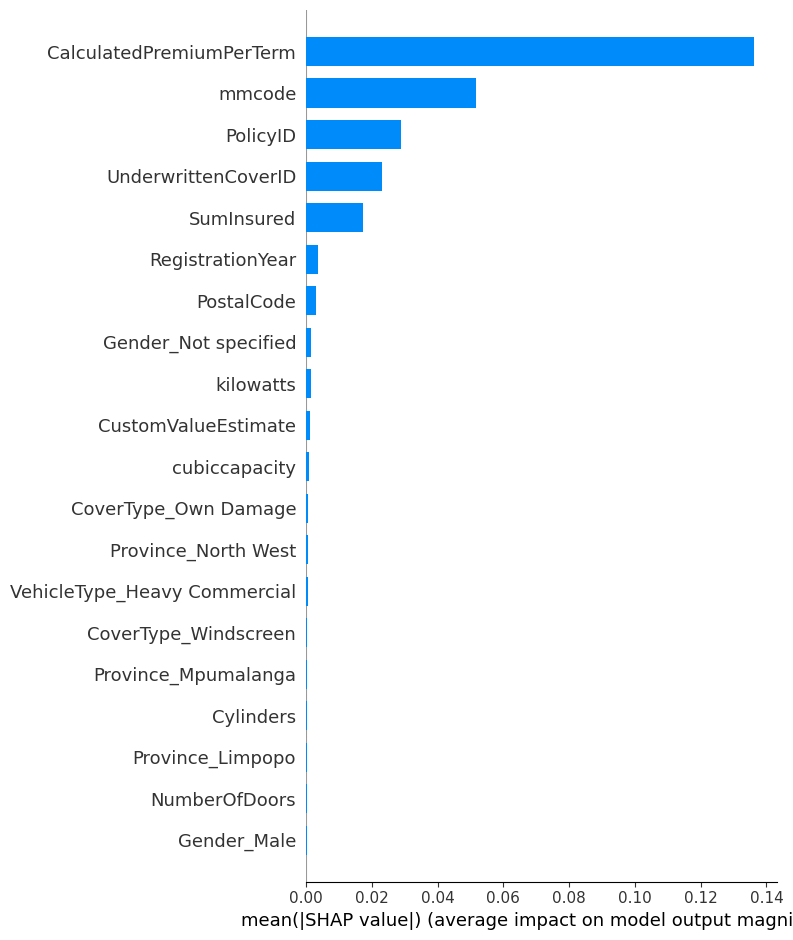

In [68]:
import shap

# Use TreeExplainer for boosted trees
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# Visualize top features
shap.summary_plot(shap_values, features=X_test, feature_names=X.columns, plot_type="bar")


In [69]:
# Set new target
target_col = 'CalculatedPremiumPerTerm'

# Drop target + claim-related columns
drop_cols = ['CalculatedPremiumPerTerm', 'TotalClaims', 'TotalPremium', 'TotalClaimAmount']

# Categorical features
categorical_cols = ['Province', 'VehicleType', 'Gender', 'Language', 'CoverType']
categorical_df = df[categorical_cols].astype('category')

# One-hot encode
encoded_df = pd.get_dummies(categorical_df, drop_first=True)

# Numeric features
numeric_df = df.select_dtypes(include=['number']).drop(columns=drop_cols, errors='ignore')

# Final features
X = pd.concat([numeric_df, encoded_df], axis=1)
y = df[target_col].copy()


In [70]:
# Drop columns with all missing values
X = X.dropna(axis=1, how='all')

# Impute missing
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Scale
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_imputed)


In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [72]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [73]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)


In [74]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest R²:", r2_score(y_test, y_pred_rf))

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))


Random Forest RMSE: 5.158826373460451
Random Forest R²: 0.9996666180702887
XGBoost RMSE: 34.09567536219283
XGBoost R²: 0.9854374031106792


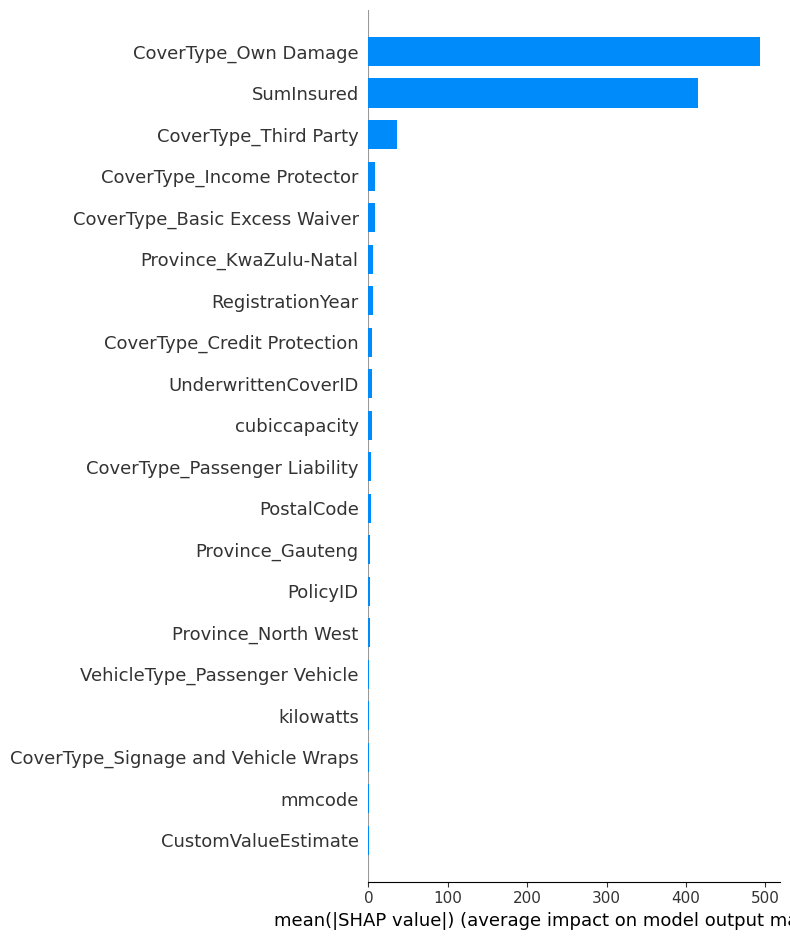

In [75]:
import shap

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# Top Features
shap.summary_plot(shap_values, features=X_test, feature_names=X.columns, plot_type="bar")


In [77]:
# Predict for new data
predictions = rf.predict(X_test)
print(predictions[:10])

[ 8.0735    6.6131    5.57845   3.664775  5.3272   25.        4.6843
  4.3331    2.0207   18.      ]


In [78]:
comparison_df = pd.DataFrame({
    "Actual": y_test[:10].values,
    "Predicted": predictions[:10]
})
print(comparison_df)

    Actual  Predicted
0   8.0735   8.073500
1   6.6131   6.613100
2   5.5807   5.578450
3   3.6690   3.664775
4   5.3272   5.327200
5  25.0000  25.000000
6   4.6843   4.684300
7   4.3331   4.333100
8   2.0207   2.020700
9  18.0000  18.000000


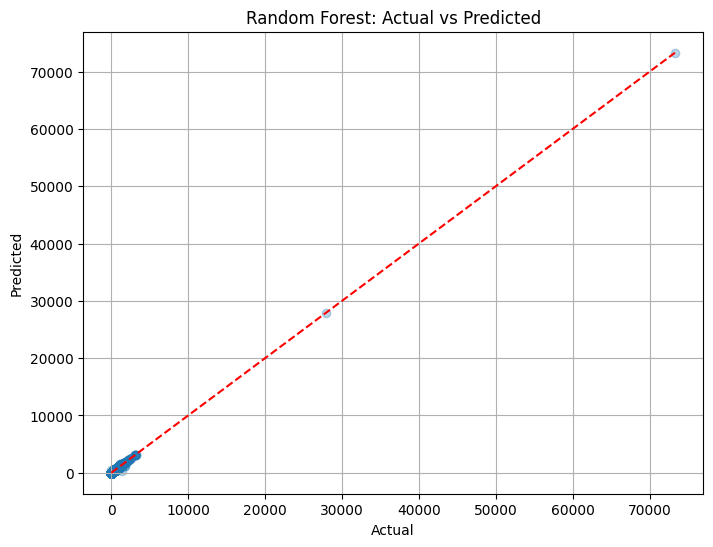

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest: Actual vs Predicted")
plt.grid(True)
plt.show()


In [80]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# R-squared
r2 = r2_score(y_test, predictions)

# MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, predictions)

# Print results
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R² (R-squared): {r2:.4f}")
print(f"✅ MAE: {mae:.2f}")


✅ RMSE: 5.16
✅ R² (R-squared): 0.9997
✅ MAE: 0.40


In [81]:
import joblib

# Save
joblib.dump(rf, 'rf_claim_model.pkl')

# Load later
rf_loaded = joblib.load('rf_claim_model.pkl')

# Use it again
rf_loaded.predict(X_test)


array([  8.0735 ,   6.6131 ,   5.57845, ...,   2.3403 , 323.0711 ,
        90.     ], shape=(200020,))